In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

In [2]:
lgb.__version__

'3.2.1'

### Load in the data

Hyperparameter tuning is extremely computationally expensive and working with the full dataset, so we only try on small subset and use the best hyperparamaters to train the entire dataset.

In [3]:
features = pd.read_csv('../data/application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels (lgb takes in array)
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

In [79]:
train_labels

array([0, 0, 0, ..., 0, 0, 0])

In [4]:
labels

array([0, 0, 0, ..., 0, 0, 1])

We will also use only the numeric features to reduce the number of dimensions which will help speed up the hyperparameter search.

In [5]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


**Cross Validation** <br/>
To use the `cv` fct, we first need to make a LightGBM `dataset`

In [6]:
train_set = lgb.Dataset(data = train_features, label = train_labels, free_raw_data=False)
test_set = lgb.Dataset(data = test_features, label = test_labels, free_raw_data=False)

In [7]:
type(train_set)

lightgbm.basic.Dataset

`num_boost_round` is the same as `n_estimators` and is set to 10000 (we use early stopping)

In [8]:
model = lgb.LGBMClassifier()
default_params = model.get_params()
default_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [9]:
#Remove the n_estimators
del default_params['n_estimators']

In [10]:
#Cross val with early stopping
cv_results = lgb.cv(default_params, train_set, 
                    num_boost_round=10000, early_stopping_rounds=100, metrics='auc', nfold = N_FOLDS, seed=12)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

C:\Users\tqluo\Anaconda3\envs\metis\lib\site-packages\lightgbm\basic.py:1222: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the trai

In [11]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.71172 with a standard deviation of 0.02089.
The optimal number of boosting rounds (estimators) was 28.


We can use this result as a baseline model to beat. To find out how well the model does on our "test" data, we will retrain it on all the training data with the best number of estimators found during cross validation with early stopping.

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
#Optimal number of estimators found in cv
model.n_estimators = len(cv_results['auc-mean'])
model.n_estimators

28

In [14]:
#Train and make predictions on test set
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('ROC AUC on test set: ', baseline_auc)

ROC AUC on test set:  0.7215389632973158


### Hyperparameter Tunning

This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to set the number of estimators (which by default is 100).

#### Objective function

The objective function takes in hyperparameters and outputs a value representing a score. Traditionally in optimization, this is a score to minimize, but here our score will be the ROC AUC which of course we want to maximize. Later, when we get to Bayesian Optimization, we will have to use a value to minimize, so we can take  **1−ROC AUC**  as the score. What occurs in the middle of the objective function will vary according to the problem, but for this problem, we will use cross validation with the specified model hyperparameters to get the cross-validation ROC AUC. This score will then be used to select the best model hyperparameter values.
<br/>
In addition to returning the value to maximize, our objective function will return the hyperparameters and the iteration of the search. These results will let us go back and inspect what occurred during a search. 

In [15]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [16]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parame

#### Domain

In [17]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [18]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

One aspect to note is that if boosting_type is goss, then we cannot use subsample (which refers to training on only a fraction of the rows in the training data, a technique known as stochastic gradient boosting). Therefore, we will need a line of logic in our algorithm that sets the subsample to 1.0 (which means use all the rows) if boosting_type=goss. As an example below, if we randomly select a set of hyperparameters, and the boosting type is "goss", then we set the subsample to 1.0.

In [19]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


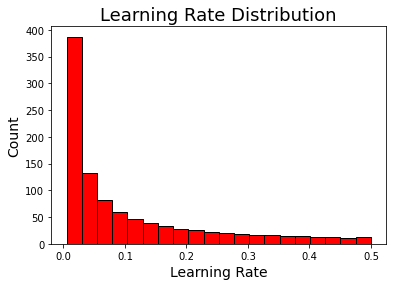

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

#### Results history

In [21]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

In [22]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [23]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

C:\Users\tqluo\Anaconda3\envs\metis\lib\site-packages\lightgbm\basic.py:1222: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[Light

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[Light

In [24]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.73319 ROC AUC on the test set.


In [25]:
pd.options.display.max_colwidth = 1000
grid_results['params'].values

array([{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'n_estimators': 629},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'n_estimators': 629},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'n_estimators': 629},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'co

### Random Search

Random search is surprisingly efficient compared to grid search. Although grid search will find the optimal value of hyperparameters (assuming they are in your grid) eventually, random search will usually find a "close-enough" value in far fewer iterations

In [26]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'num_leaves': 88,
 'learning_rate': 0.027778881111994384,
 'subsample_for_bin': 220000,
 'min_child_samples': 175,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0,
 'is_unbalance': False}

Next, we define the `random_search` function. This takes the same general structure as grid_search except for the method used to select the next hyperparameter values. Moreover, random search is always run with a limit on the number of search iterations.

In [27]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [28]:
# #This block tooks 15mins

# random_results = random_search(param_grid)

# print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
# print('\nThe best hyperparameters were:')

# import pprint
# pprint.pprint(random_results.loc[0, 'params'])

In [30]:
# # Get the best parameters
# random_search_params = random_results.loc[0, 'params']

# # Create, train, test model
# model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
# model.fit(train_features, train_labels)

# preds = model.predict_proba(test_features)[:, 1]

# print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

In [ ]:
random_results['params']

### Stacking Random and Grid Search

Keep the progress in csv file

In [31]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

Modify `random_search` and `grid_search` to write to this file every time. We do this by opening a connection, this time using the "a" option for append (the first time we used the "w" option for write) and writing a line with the desired information (which in this case is the cross validation score, the hyperparameters, and the number of the iteration). Then we close the connection until the function is called again.

In [32]:
def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 

In [33]:
def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [ ]:
# #This block of codes took 1h40mins to run in my machine
# MAX_EVALS = 1000

# # Create file and open connection
# out_file = 'grid_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# grid_results = grid_search(param_grid, out_file)



In [ ]:
# #This block took 1h22min
# # Create file and open connection
# out_file = 'random_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# random_results = random_search(param_grid, out_file)

### Results on Limited Data

In [34]:
random_results = pd.read_csv('random_search_trials_1000.csv')
grid_results = pd.read_csv('grid_search_trials_1000.csv')

When we save the results to a csv, for some reason the dictionaries are saved as strings. Therefore we need to convert them back to dictionaries after reading in the results using the `ast.literal_eval` function.

In [35]:
import ast

# Convert strings to dictionaries
grid_results['hyperparameters'] = grid_results['hyperparameters'].map(ast.literal_eval)
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)

In [36]:
grid_results['hyperparameters']

0                                     {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'n_estimators': 629}
1                                    {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'n_estimators': 629}
2                      {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'n_estimators': 629}
3                     {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'sub

In [37]:
random_results['hyperparameters']

0                          {'n_estimators': 13, 'subsample_for_bin': 60000, 'learning_rate': 0.2849218529734569, 'num_leaves': 100, 'metric': 'auc', 'boosting_type': 'dart', 'verbose': 1, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.5, 'reg_alpha': 0.836734693877551, 'min_child_samples': 485, 'is_unbalance': False, 'reg_lambda': 0.7755102040816326}
1             {'n_estimators': 18, 'subsample_for_bin': 40000, 'learning_rate': 0.1881679181143267, 'num_leaves': 113, 'metric': 'auc', 'boosting_type': 'dart', 'verbose': 1, 'colsample_bytree': 0.7777777777777778, 'subsample': 0.98989898989899, 'reg_alpha': 0.8775510204081632, 'min_child_samples': 150, 'is_unbalance': True, 'reg_lambda': 0.3877551020408163}
2      {'n_estimators': 514, 'subsample_for_bin': 180000, 'learning_rate': 0.009402520275642907, 'num_leaves': 29, 'metric': 'auc', 'boosting_type': 'gbdt', 'verbose': 1, 'colsample_bytree': 0.8222222222222222, 'subsample': 0.7575757575757576, 'reg_alpha': 0.22448979591836732, 

Now let's make a function to parse the results from the hyperparameter searches. This returns a dataframe where each column is a hyperparameter and each row has one search result (so taking the dictionary of hyperparameters and mapping it into a row in a dataframe).

In [38]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df

In [39]:
grid_hyp = evaluate(grid_results, name = 'grid search')

The highest cross validation score from grid search was 0.72024 found on iteration 0.
ROC AUC from grid search on test data = 0.73471.


In [40]:
random_hyp = evaluate(random_results, name = 'random search')

The highest cross validation score from random search was 0.73448 found on iteration 596.
[LightGBM] [Info] Number of positive: 817, number of negative: 9183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081700 -> initscore=-2.419470
[LightGBM] [Info] Start training from score -2.419470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [41]:
hyperparameters = dict(**random_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

In [42]:
hyperparameters

{'subsample_for_bin': 60000,
 'learning_rate': 0.2849218529734569,
 'num_leaves': 100,
 'metric': 'auc',
 'boosting_type': 'dart',
 'verbose': 1,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.5,
 'reg_alpha': 0.836734693877551,
 'min_child_samples': 485,
 'is_unbalance': False,
 'reg_lambda': 0.7755102040816326}

### Train on full dataset with the `hyperparameters` we found

In [43]:
app_train = pd.read_csv('app_train.csv', index_col=0)
print(app_train.shape)
app_train.head()

(307511, 247)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,637.0,...,0,0,0,0,0,1,0,1,0,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,1188.0,...,1,0,0,0,0,0,0,1,0,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,225.0,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,3039.0,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,3038.0,...,0,0,0,0,0,0,0,0,0,False


In [44]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
print(app_train.shape)
app_train.head()

(307511, 251)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,637.0,...,0,1,0,1,0,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,1188.0,...,0,0,0,1,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,225.0,...,0,0,0,0,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,3039.0,...,0,0,0,0,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,3038.0,...,0,0,0,0,0,False,4.222222,0.179963,0.042623,-0.152418


In [45]:
X = app_train.drop(columns=['TARGET'])
y = app_train.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)
y_train shape:  (246008,)
y_test shape:  (61503,)


In [48]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#features columns
features = list(X_train.columns)

#test set

#SimpleImputer wirth strategy = median
imputer = SimpleImputer(strategy='median')

#Scale the features
scaler = StandardScaler()

#Fit on the training data

#Imputer
imputer.fit(X_train_lr)
X_train_lr = imputer.transform(X_train_lr)
X_test_lr = imputer.transform(X_test_lr)

#Scaler
scaler.fit(X_train_lr)
X_train_lr = scaler.transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

print('X_train shape: ', X_train_lr.shape)
print('X_test shape: ', X_test_lr.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)


In [57]:
y_train_lgb = np.array(y_train.astype(np.int32)).reshape((-1, ))
y_test_lgb = np.array(y_test.astype(np.int32)).reshape((-1, ))

In [60]:
train_set_lgb = lgb.Dataset(data=X_train, label=y_train_lgb, free_raw_data=False)

In [63]:
type(train_set_lgb)

lightgbm.basic.Dataset

In [61]:
hyperparameters

{'subsample_for_bin': 60000,
 'learning_rate': 0.2849218529734569,
 'num_leaves': 100,
 'metric': 'auc',
 'boosting_type': 'dart',
 'verbose': 1,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.5,
 'reg_alpha': 0.836734693877551,
 'min_child_samples': 485,
 'is_unbalance': False,
 'reg_lambda': 0.7755102040816326}

In [70]:
#Cross val with early stopping
cv_results = lgb.cv(hyperparameters, train_set=train_set_lgb, 
                    num_boost_round=200, early_stopping_rounds=10, metrics='auc', nfold = N_FOLDS, seed=12)

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12271
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 207
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12271
[LightGBM] [Info] Number of d

C:\Users\tqluo\Anaconda3\envs\metis\lib\site-packages\lightgbm\callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


In [71]:
print('The cross validation score on the full dataset = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset = 0.74812 with std: 0.00254.
Number of estimators = 200.


In [75]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)


In [96]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model.fit(X_train, y_train_lgb)

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12271
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

LGBMClassifier(boosting_type='dart', colsample_bytree=0.8222222222222222,
               is_unbalance=False, learning_rate=0.2849218529734569,
               metric='auc', min_child_samples=485, n_estimators=200,
               num_leaves=100, reg_alpha=0.836734693877551,
               reg_lambda=0.7755102040816326, subsample=0.5,
               subsample_for_bin=60000, verbose=1)

In [97]:
preds = model.predict_proba(X_test)[:, 1]

In [98]:
preds_hard = model.predict(X_test)

In [102]:
#Test sets
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, fbeta_score
print(roc_auc_score(y_test, preds))
print(f1_score(y_test, preds_hard))

0.7599108566250459
0.059519267455169785


In [101]:
print(precision_score(y_test, preds_hard))
print(recall_score(y_test, preds_hard))

0.5324232081911263
0.031521519498888664


In [105]:
fbeta_score(y_test, preds_hard, 0.5)

C:\Users\tqluo\Anaconda3\envs\metis\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.1274301584708381

### Results